# 感情分析のための日本語BERTのfinetuning

* Transformersについては、例えば、下記のWebページを参照。
 * http://nlp.seas.harvard.edu/2018/04/03/attention.html

* 今回は、Hugging FaceのTransformersを使う。
 * https://huggingface.co/docs/transformers/

* ランタイムのタイプはGPUにしておく。

## transformersのインストール

In [2]:
!pip install transformers[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.4 MB/s eta 0:00:00


### トークナイザを動かすために必要なモジュールのインストール

In [3]:
!pip install fugashi ipadic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.9/615.9 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=1add42fa4f2e8fffb14a86f6bc9ec0ac26b286597b1d48657f17dd8bcdc016e2
  Stored in directory: /root/.cache/pip/wheels/45/b7/f5/a21e68db846eedcd00d69e37d60bab3f68eb20b1d99cdff652
Successfully built ipadic


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

np.random.seed(123)
torch.manual_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 日本語BERTとしては、今回、下記のモデルを使う。
MODEL_NAME = "cl-tohoku/bert-base-japanese-whole-word-masking"

## データセット

### WRIME: 主観と客観の感情分析データセット
* https://github.com/ids-cv/wrime

* このデータセットは、元々は-2, -1, 0, ,1 2の５値で感情極性を表現している。
* 今回は、**ネガティブ、ニュートラル、ポジティブの3値**に単純化することにする。
 * 余裕がある方は、5値分類のままファインチューニングを実施してみてください。

In [5]:
!wget https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver2.tsv

--2023-01-20 13:25:53--  https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8182156 (7.8M) [text/plain]
Saving to: ‘wrime-ver2.tsv’

wrime-ver2.tsv      100%[===================>]   7.80M  --.-KB/s    in 0.04s   

2023-01-20 13:25:54 (222 MB/s) - ‘wrime-ver2.tsv’ saved [8182156/8182156]



In [6]:
df = pd.read_csv("wrime-ver2.tsv", sep="\t")
df.head()

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Sentiment,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust,Avg. Readers_Sentiment
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,1,2012/7/31 23:48,train,0,1,2,1,1,0,...,-1,0,2,0,0,0,0,0,0,-1
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,1,2012/8/2 23:09,train,3,0,3,0,0,0,...,1,1,0,0,2,0,0,0,0,1
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,1,2012/8/5 0:50,train,1,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,0
3,眠い、眠れない。,1,2012/8/8 1:36,train,0,2,1,0,0,1,...,-1,0,1,0,0,0,0,1,0,-1
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,1,2012/8/9 22:24,train,2,1,3,2,0,1,...,0,1,0,0,1,0,0,0,0,0


* データセットはすでにTrain/Dev/Testの3つの部分に分けられている。

In [7]:
split_tags = list(df["Train/Dev/Test"].unique())
split_tags

['train', 'test', 'dev']

* 今回は、ポジティヴ／ニュートラル／ネガティヴの3値分類問題として、感情分析を行なう。

In [8]:
df_sentiment = df[['Train/Dev/Test', 'Avg. Readers_Sentiment', 'Sentence']]

* ポジティブのラベルを2、ネガティブのラベルを1、ニュートラルのラベルを0と設定する。

In [9]:
df_sentiment.loc[df['Avg. Readers_Sentiment'] > 0, 'Target'] = 2
df_sentiment.loc[df['Avg. Readers_Sentiment'] < 0, 'Target'] = 1
df_sentiment.loc[df['Avg. Readers_Sentiment'] == 0, 'Target'] = 0

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


* 各クラスのテキスト数を調べる。

In [10]:
print(f"{(df_sentiment['Target'] == 2).sum()} positive texts")
print(f"{(df_sentiment['Target'] == 1).sum()} negative texts")
print(f"{(df_sentiment['Target'] == 0).sum()} neutral texts")

11383 positive texts
12155 negative texts
11462 neutral texts


* クラス数を変数`num_class`に保存しておく。

In [11]:
num_class = len(df_sentiment["Target"].unique())
print(num_class)

3


* データセットで元々指定されたtrain/dev/testの分割のまま、データセットを分割する。

In [12]:
df_splits = {}
for split_tag in split_tags:
  df_splits[split_tag] = df_sentiment[df_sentiment['Train/Dev/Test'] == split_tag][['Target', 'Sentence']]

In [13]:
df_splits["train"].head()

,Target,Sentence
0,1.0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…
1,2.0,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...
2,0.0,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。
3,1.0,眠い、眠れない。
4,0.0,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!


## Dataset

* データフレームからPyTorchのDatasetを作る。

In [14]:
class MyDataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    return self.df.iloc[idx]['Sentence'], self.df.iloc[idx]['Target']

In [15]:
wrime = {}
for split_tag in split_tags:
  wrime[split_tag] = MyDataset(df_splits[split_tag])

In [16]:
wrime["train"][0]

('ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…', 1.0)

## トークナイザ

* 日本語BERTのトークナイザをダウンロードしておく。

In [17]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

In [18]:
tokenizer

PreTrainedTokenizer(name_or_path='cl-tohoku/bert-base-japanese-whole-word-masking', vocab_size=32000, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

* 試しに、一つのテキストをトークナイズしてみる。

In [19]:
model_inputs = tokenizer(wrime["train"][0][0], padding=True, return_tensors="pt")
print(model_inputs)

{'input_ids': tensor([[    2,  3937, 28517, 26099,    15,    16,  3318, 12272,   640,     8,
          1131, 28479,    31,    40,  2949,     7,    12,  1549,  5602,  3215,
             3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


* `token_type_ids`については、下記URLを参照。
 * https://huggingface.co/docs/transformers/main/en/glossary#token-type-ids

* インデックスの列をトークン列に戻してみる。
 * 先頭と末尾のspecial tokensに注意。

In [20]:
print(tokenizer.convert_ids_to_tokens(model_inputs['input_ids'][0]))

['[CLS]', 'ぼ', '##け', 'っと', 'し', 'て', 'たら', 'こんな', '時間', '。', 'チャ', '##リ', 'ある', 'から', '食べ', 'に', 'で', 'たい', 'のに', '...', '[SEP]']


## DataLoader

* PyTorchのDataLoaderを利用して、ミニバッチをランダムな順で取ってこれるようにする。

* どんなミニバッチにしたいかをcollation用関数で定義する。
 * テキストはトークナイザを通した状態でミニバッチに含ませる。
 * ラベルはPyTorchのTensorに変換してミニバッチに含ませる。

* 今回使っているトークナイザは、テキストの長さが揃っていないときのpaddingの処理までおこなってくれる。

In [21]:
def collate_fn(batch):
  texts, labels = zip(*batch)
  model_inputs = tokenizer(texts, padding=True, return_tensors="pt")
  return model_inputs.to(device), torch.tensor(labels).long().to(device)

* Train/Dev/Testの各スプリットについて、DataLoaderのインスタンスを作成する。
 * ミニバッチのサイズは、チューニングした方が良い。

In [22]:
def getLoader(BATCH_SIZE):
  loaders = {}
  for split_tag in split_tags:
    loaders[split_tag] = DataLoader(
        wrime[split_tag],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        )
  return loaders

* 試しに、一個、ミニバッチを訓練データから取得してみる。

In [23]:
#input, label = next(iter(loaders["train"]))
#print(input)
#print(label)

## 事前学習済み日本語BERT

### 事前学習済みモデルのダウンロード

In [24]:
bert = AutoModel.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

* このBERTの単語埋め込みの次元数を調べる。

In [26]:
bert.embeddings.word_embeddings.weight.shape

torch.Size([32000, 768])

* このBERTのlayer数を調べる。

In [27]:
len(bert.encoder.layer)

12

* 最後のlayerだけ表示する。

In [28]:
bert.encoder.layer[-1]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

### pooler
* poolerは、最初のトークンに対応する出力を受け取っている。
 * https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py#L652
* 活性化関数tanhを使っている。

In [29]:
bert.pooler

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

## 分類モデルの定義

In [30]:
class BERTTextSentiment(nn.Module):
  def __init__(self, bert, num_class):
    super().__init__()
    self.bert = bert
    self.embdim = bert.embeddings.word_embeddings.weight.size(1)
    self.num_class = num_class
    self.fc = nn.Linear(self.embdim * 2, self.num_class)

  def forward(self, input):
    output = self.bert(**input)
    pooler_output = output.pooler_output # [CLS]に対応するhidden state
    # poolerに合わせて、tanhを適用しておく。
    # last_hidden_state (batch size, seq len, hidden dim)
    mean_output = torch.tanh(output.last_hidden_state).mean(1)
    logit = self.fc(torch.cat([pooler_output, mean_output], -1))
    return logit

In [31]:
# model = BERTTextSentiment(bert, num_class).to(device)

def newModel():
  model = BERTTextSentiment(bert, num_class).to(device)

  # 最後のlayerと、poolerだけfinetuningするよう、設定する
  for param in model.bert.parameters():
    param.requires_grad = False
  for param in model.bert.encoder.layer[-1].parameters():
    param.requires_grad = True
  for param in model.bert.pooler.parameters():
    param.requires_grad = True
  
  #print(model)
  return model


* 最後のlayerと、poolerだけfinetuningするよう、設定する。

In [32]:
#for param in model.bert.parameters():
#  param.requires_grad = False
#for param in model.bert.encoder.layer[-1].parameters():
#  param.requires_grad = True
#for param in model.bert.pooler.parameters():
#  param.requires_grad = True

* 試しに、ミニバッチを入力してみる。

In [33]:
#input, _ = next(iter(loaders["train"]))
#logit = model(input)
#print(logit)

## 最適化アルゴリズムと損失関数

* 学習率はチューニングする必要あり。

In [34]:
def getOptimizer(learning_rate):
  return torch.optim.AdamW(model.parameters(), lr=learning_rate)

#optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

## 訓練を行なう関数

In [35]:
def train(dataloader):
  model.train()
  total_loss, total_acc, total_count = 0, 0, 0
  for i, batch in enumerate(dataloader):
    input, label = batch
    logit = model(input)
    loss = criterion(logit, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    n_instances = label.size(0)
    total_loss += loss.item() * n_instances
    total_acc += (logit.argmax(-1) == label).sum().item()
    total_count += n_instances
    #if (i + 1) % 100 == 0:
    #  print(f"===>{i+1} | acc {total_acc/total_count:.4f}")
  return total_loss / total_count, total_acc / total_count


## 評価を行なう関数

In [36]:
def evaluation(dataloader):
  model.eval()
  total_loss, total_acc, total_count = 0, 0, 0
  for i, batch in enumerate(dataloader):
    input, label = batch
    with torch.no_grad():
      logit = model(input)
      loss = criterion(logit, label)
    n_instances = label.size(0)
    total_loss += loss.item() * n_instances
    total_acc += (logit.argmax(-1) == label).sum().item()
    total_count += n_instances
    #if (i + 1) % 100 == 0:
    #  print(f"===>{i+1} | acc {total_acc/total_count:.4f}")
  return total_loss / total_count, total_acc / total_count

# 課題7（finetuningの実行） 
* 分類性能が上がるよう、ハイパーパラメータをチューニングしてみよう。
 * 学習率、ミニバッチのサイズ、分類用の全結合層の層数、etc...
* [発展] 今回のデータセットの、元々の5値分類で、finetuningを実行してみよう。

## 学習率

### 訓練

In [ ]:
import datetime

lrList = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

# 学習率別で、Validate Dataの上で、全epocheの平均値リスト
valid_los_list_mean_lr, valid_acc_list_mean_lr = [], []

for lr in lrList:
 
  curtime = datetime.datetime.now().strftime('%H.%M.%S')
  print(f'======learning rate {lr}, START TIME: {curtime} ===== ') 

  # モデル初期化
  model = newModel()
  # optimizer生成
  optimizer = getOptimizer(lr)

  # データロード(BATCH_SIZEを固定)
  loaders = getLoader(8)

  # Validate Dataの上で、　各epocheの値リスト
  valid_los_list_lr, valid_acc_list_lr = [], []

  for epoch in range(1, 6):

    loss, acc = train(loaders["train"])
    dev_loss, dev_acc = evaluation(loaders["dev"])

    # 各epoch,Validデータの学習率のスーコア
    valid_acc_list_lr.append(dev_acc)
    valid_los_list_lr.append(dev_loss)

    print(f'> epoch {epoch} | train loss {loss:.3f} | train acc {acc:.4f} || '
        f'dev loss {dev_loss:.3f} | dev acc {dev_acc:.4f}')
  
  # 全epoch,Validデータの学習率の平均スーコア
  valid_acc_list_mean_lr.append(np.mean(valid_acc_list_lr))
  valid_los_list_mean_lr.append(np.mean(valid_los_list_lr))

  print(f'======learning rate {lr} END===== '
        f'mean valid accuracy {np.mean(valid_acc_list_lr):5.3f} | '
        f'mean valid loss {np.mean(valid_los_list_lr):5.3f} | ')

======learning rate 0.01, START TIME: 10.17.19 ===== 
> epoch 1 | train loss 1.764 | train acc 0.3910 || dev loss 1.253 | dev acc 0.3660
> epoch 2 | train loss 1.711 | train acc 0.4438 || dev loss 3.948 | dev acc 0.3136
> epoch 3 | train loss 1.714 | train acc 0.4812 || dev loss 0.999 | dev acc 0.5896
> epoch 4 | train loss 1.700 | train acc 0.4935 || dev loss 1.397 | dev acc 0.5152
> epoch 5 | train loss 1.686 | train acc 0.5064 || dev loss 1.977 | dev acc 0.5340
======learning rate 0.01 END===== mean valid accuracy 0.464 | mean valid loss 1.915 | 
======learning rate 0.001, START TIME: 10.30.47 ===== 
> epoch 1 | train loss 0.890 | train acc 0.5998 || dev loss 0.900 | dev acc 0.5760
> epoch 2 | train loss 0.869 | train acc 0.6083 || dev loss 0.859 | dev acc 0.6024
> epoch 3 | train loss 0.853 | train acc 0.6159 || dev loss 0.904 | dev acc 0.5912
> epoch 4 | train loss 0.839 | train acc 0.6237 || dev loss 0.814 | dev acc 0.6096
> epoch 5 | train loss 0.837 | train acc 0.6304 || dev lo

### 考査
Validateデータの訓練結果により、learning rateは0.0001と1e-05の場合、正解スーコアと損失値は大体同じです。。

なので、次のチューニングでlearning rateは0.0001を設定する

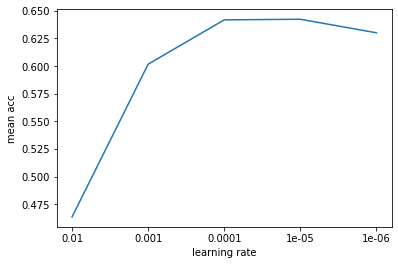

In [ ]:
from matplotlib import pyplot as plt

x_lr = [1, 2, 3, 4, 5]
plt.plot(x_lr, valid_acc_list_mean_lr)
plt.xlabel("learning rate")
plt.ylabel("mean acc")
plt.xticks(x_lr, [0.01,0.001, 0.0001, 0.00001, 0.000001])
plt.show()

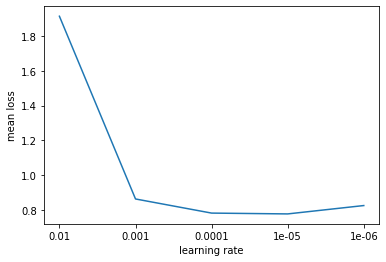

In [ ]:
x_lr = [1, 2, 3, 4, 5]
plt.plot(x_lr, valid_los_list_mean_lr)
plt.xlabel("learning rate")
plt.ylabel("mean loss")
plt.xticks(x_lr, [0.01,0.001, 0.0001, 0.00001, 0.000001])
plt.show()

## ミニバッチのサイズ

### 訓練

In [ ]:
BATCH_SIZE_LIST = [8, 16, 32, 64, 128]

# バッチサイズ別で、Validate Dataの上で、全epocheの平均値リスト
valid_los_list_mean_bt, valid_acc_list_mean_bt = [], []

for bt in BATCH_SIZE_LIST:
  
  curtime = datetime.datetime.now().strftime('%H.%M.%S')
  print(f'======batch size {bt}, START TIME: {curtime} ===== ') 

  # モデル初期化
  model = newModel()
  # optimizer生成(learning rateを固定)
  optimizer = getOptimizer(0.0001)

  # データロード
  loaders = getLoader(bt)

  # Validate Dataの上で、　各epocheの値リス
  valid_los_list_bt, valid_acc_list_bt = [], []

  for epoch in range(1, 6):

    loss, acc = train(loaders["train"])
    dev_loss, dev_acc = evaluation(loaders["dev"])

    # 各epoch,Validデータのスーコア
    valid_acc_list_bt.append(dev_acc)
    valid_los_list_bt.append(dev_loss)

    print(f'> epoch {epoch} | train loss {loss:.3f} | train acc {acc:.4f} || '
        f'dev loss {dev_loss:.3f} | dev acc {dev_acc:.4f}')
  
  # 全epoch,Validデータの学習率の平均スーコア
  valid_acc_list_mean_bt.append(np.mean(valid_acc_list_bt))
  valid_los_list_mean_bt.append(np.mean(valid_los_list_bt))

  print(f'======batch size {bt} END===== '
        f'mean valid accuracy {np.mean(valid_acc_list_bt):5.3f} | '
        f'mean valid loss {np.mean(valid_los_list_bt):5.3f} | ')

======batch size 8, START TIME: 11.34.32 ===== 
> epoch 1 | train loss 0.758 | train acc 0.6588 || dev loss 0.783 | dev acc 0.6452
> epoch 2 | train loss 0.744 | train acc 0.6635 || dev loss 0.785 | dev acc 0.6400
> epoch 3 | train loss 0.741 | train acc 0.6654 || dev loss 0.776 | dev acc 0.6428
> epoch 4 | train loss 0.737 | train acc 0.6689 || dev loss 0.781 | dev acc 0.6412
> epoch 5 | train loss 0.738 | train acc 0.6674 || dev loss 0.784 | dev acc 0.6420
======batch size 8 END===== mean valid accuracy 0.642 | mean valid loss 0.782 | 
======batch size 16, START TIME: 11.47.23 ===== 
> epoch 1 | train loss 0.764 | train acc 0.6541 || dev loss 0.777 | dev acc 0.6384
> epoch 2 | train loss 0.735 | train acc 0.6713 || dev loss 0.771 | dev acc 0.6468
> epoch 3 | train loss 0.734 | train acc 0.6684 || dev loss 0.771 | dev acc 0.6460
> epoch 4 | train loss 0.732 | train acc 0.6717 || dev loss 0.776 | dev acc 0.6460
> epoch 5 | train loss 0.730 | train acc 0.6718 || dev loss 0.775 | dev acc

### 考査
batch_sizeを変えるにつれて、正解スーコアと損失値も変りました。でも、差異は小さいです。

結果により、64の場合、正解スーコアは一番高いです。なので、batch_sizeが64を設定する。

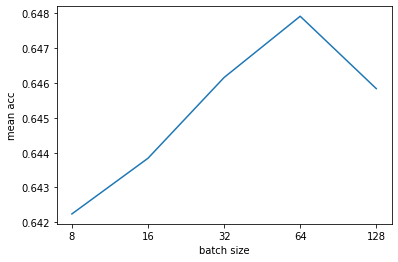

In [ ]:
x_bt = [1, 2, 3, 4, 5]
plt.plot(x_bt, valid_acc_list_mean_bt)
plt.xlabel("batch size")
plt.ylabel("mean acc")
plt.xticks(x_bt, [8, 16, 32, 64, 128])
plt.show()

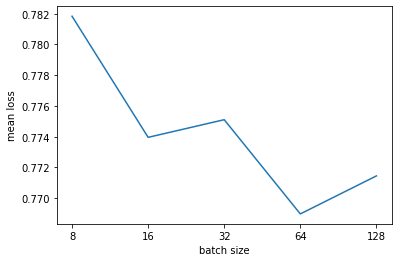

In [ ]:
x_bt = [1, 2, 3, 4, 5]
plt.plot(x_lr, valid_los_list_mean_bt)
plt.xlabel("batch size")
plt.ylabel("mean loss")
plt.xticks(x_bt, [8, 16, 32, 64, 128])
plt.show()

## 全結合層の層数

### ２層の全結合層

#### モデル定義

In [46]:
class BERTTextSentimentLay2(nn.Module):
  def __init__(self, bert, num_class):
    super().__init__()
    self.bert = bert
    # self.embdim:768
    self.embdim = bert.embeddings.word_embeddings.weight.size(1)
    self.num_class = num_class
    self.fc1 = nn.Linear(self.embdim * 2, self.embdim)
    self.fc2 = nn.Linear(self.embdim, self.num_class)

  def forward(self, input):
    output = self.bert(**input)
    # pooler_output.shape:(batch_size, 768)
    pooler_output = output.pooler_output # [CLS]に対応するhidden state

    # poolerに合わせて、tanhを適用しておく。
    # last_hidden_state (batch size, seq len, hidden dim)
    # output.last_hidden_state.shape:[8, 64, 768]
    mean_output = torch.tanh(output.last_hidden_state).mean(1)

    # mean_output.shape:[batch_size, 768]
    # torch.cat().shape:[batch_size, 1536]

    logit = self.fc1(torch.cat([pooler_output, mean_output], -1))
    # logit.shape:[batch_size, 768]

    logit = self.fc2(logit)
    # logit.shape:[batch_size, 3]
    
    return logit

In [42]:
def newModelLay(BERTTextSentimentLay):
  modelLay = BERTTextSentimentLay(bert, num_class).to(device)

  # 最後のlayerと、poolerだけfinetuningするよう、設定する
  for param in modelLay.bert.parameters():
    param.requires_grad = False
  for param in modelLay.bert.encoder.layer[-1].parameters():
    param.requires_grad = True
  for param in modelLay.bert.pooler.parameters():
    param.requires_grad = True
  
  #print(model)
  return modelLay

#### 訓練

In [45]:
# モデル初期化
model = newModelLay(BERTTextSentimentLay2)

# optimizer生成
# 0.0001を固定
optimizer = getOptimizer(0.0001)

# データロード(BATCH_SIZE：64を固定)
loaders = getLoader(64)

# Validate Dataの上で、　各epocheの値リスト
valid_los_list_lr, valid_acc_list_lr= [], []

for epoch in range(1, 6):

  loss, acc = train(loaders["train"])
  dev_loss, dev_acc = evaluation(loaders["dev"])

  # 各epoch,Validデータの学習率のスーコア
  valid_acc_list_lr.append(dev_acc)
  valid_los_list_lr.append(dev_loss)

  print(f'> epoch {epoch} | train loss {loss:.3f} | train acc {acc:.4f} || '
      f'dev loss {dev_loss:.3f} | dev acc {dev_acc:.4f}')

> epoch 1 | train loss 0.820 | train acc 0.6183 || dev loss 0.750 | dev acc 0.6608
> epoch 2 | train loss 0.735 | train acc 0.6695 || dev loss 0.731 | dev acc 0.6752
> epoch 3 | train loss 0.684 | train acc 0.6935 || dev loss 0.711 | dev acc 0.6792
> epoch 4 | train loss 0.640 | train acc 0.7188 || dev loss 0.732 | dev acc 0.6796
> epoch 5 | train loss 0.589 | train acc 0.7433 || dev loss 0.725 | dev acc 0.6856


### ３層の全結合層

#### モデル定義

In [47]:
class BERTTextSentimentLay3(nn.Module):
  def __init__(self, bert, num_class):
    super().__init__()
    self.bert = bert
    # self.embdim:768
    self.embdim = bert.embeddings.word_embeddings.weight.size(1)
    self.num_class = num_class
    self.fc1 = nn.Linear(self.embdim * 2, self.embdim)
    self.fc2 = nn.Linear(self.embdim, 384)
    self.fc3 = nn.Linear(384, self.num_class)

  def forward(self, input):
    output = self.bert(**input)
    # pooler_output.shape:(batch_size, 768)
    pooler_output = output.pooler_output # [CLS]に対応するhidden state

    # poolerに合わせて、tanhを適用しておく。
    # last_hidden_state (batch size, seq len, hidden dim)
    # output.last_hidden_state.shape:[8, 64, 768]
    mean_output = torch.tanh(output.last_hidden_state).mean(1)

    # mean_output.shape:[batch_size, 768]
    # torch.cat().shape:[batch_size, 1536]

    logit = self.fc1(torch.cat([pooler_output, mean_output], -1))

    logit = self.fc2(logit)
    logit = self.fc3(logit)
    
    return logit

#### 訓練

In [48]:
# モデル初期化
model = newModelLay(BERTTextSentimentLay3)

# optimizer生成
# 0.0001を固定
optimizer = getOptimizer(0.0001)

# データロード(BATCH_SIZE：64を固定)
loaders = getLoader(64)

# Validate Dataの上で、　各epocheの値リスト
valid_los_list_lr, valid_acc_list_lr= [], []

for epoch in range(1, 6):

  loss, acc = train(loaders["train"])
  dev_loss, dev_acc = evaluation(loaders["dev"])

  # 各epoch,Validデータの学習率のスーコア
  valid_acc_list_lr.append(dev_acc)
  valid_los_list_lr.append(dev_loss)

  print(f'> epoch {epoch} | train loss {loss:.3f} | train acc {acc:.4f} || '
      f'dev loss {dev_loss:.3f} | dev acc {dev_acc:.4f}')

> epoch 1 | train loss 0.542 | train acc 0.7698 || dev loss 0.771 | dev acc 0.6668
> epoch 2 | train loss 0.480 | train acc 0.7986 || dev loss 0.797 | dev acc 0.6672
> epoch 3 | train loss 0.423 | train acc 0.8266 || dev loss 0.924 | dev acc 0.6648
> epoch 4 | train loss 0.371 | train acc 0.8488 || dev loss 0.972 | dev acc 0.6528
> epoch 5 | train loss 0.311 | train acc 0.8779 || dev loss 1.071 | dev acc 0.6608


## finetuningの考査纏め
* finetuning1:学習率

 * 学習率[0.01, 0.001, 0.0001, 0.00001, 0.000001]の訓練結果により、検証データの上で、0.01の場合、平均scoreは一番低い、0.475ぐらいです。0.0001の場合、平均scoreは一番高い、0.645ぐらいです。学習率は性能に影響が大きいです。

* finetuning2:ミニバッチのサイズ。

 * バッチサイズ[8, 16, 32, 64, 128]の訓練結果により、scoreの差異が小さいです。該当データセットの上で、バッチサイズを変えるにつれて、性能に影響が小さいです。

* finetuning3:分類用の全結合層の層数
 * epocheは５回の前提で、2層の場合、最後のscoreは0.6856。１層より良くなりました。でも、3層の場合、最後scoreは0.6608。層は深くなって、性能は上がらないです。なので、全結合層の層数は２層に設定すれば良いです。


